# Preamble

This notebook is used for experimental development & interactive training. Most code related to data generation, model definitions and solvers is in the [GitHub repository](https://github.com/SteffenBe/ADL4CV) and then loaded here.

In [1]:
!rm -rf repo/
!git clone https://github.com/SteffenBe/ADL4CV repo 2> /dev/null
!ls repo

adl4cv_poster.pptx  models_gan.py	     solver_gan.py
dataset.py	    models.py		     solver_modifier.py
default_image.png   README.md		     solver.py
example-images	    relevant_glove_dict.pkl  text_creation.py
glove_dict.pkl	    requirements.txt	     trained-models
image_creation.py   solver_cgan.py	     vocab.py


In [3]:
# Note: There seems to be some problem with autoload and file uploads.
# Sometimes it doesn't update the loaded module. Don't trust it too much ...
%load_ext autoreload
%autoreload 2

# Want to use pytorch 1.4.0 (instead of default 1.3.1) because it fixed a bug
# with nn.Embedding not respecting "padding_idx" parameter.
!pip install torch>=1.4.0

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import itertools
import copy

import repo.image_creation as image_creation
import repo.text_creation as text_creation
import repo.dataset as dataset
import repo.models as models
from repo.models_gan import Generator, Discriminator
from repo.vocab import Vocabulary
from repo.solver import Solver, triplet_loss
from repo.solver_cgan import SolverCGAN
from repo.solver_modifier import SolverModifier

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

%matplotlib inline

print("Torch version:", torch.__version__)
if torch.cuda.is_available():
  print("CUDA available!")
  device = torch.device("cuda:0")
  print(torch.cuda.get_device_properties(device))
else:
  print("CUDA not available!")
  device = torch.device("cpu")

Torch version: 1.4.0
CUDA available!
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


# Global variables

Set some numbers that are relevant to **multiple** steps below.

In [0]:
# Set to None to train a model. Set to the path of a serialized model to skip that training step.
pretrained_joint_model_path = "repo/trained-models/joint_model--347713--2020-01-21T22-08.pt"
pretrained_generator_path = "repo/trained-models/generator--394563--2020-02-02T18-40.pt"
pretrained_discriminator_path = "repo/trained-models/discriminator--270145--2020-02-02T18-40.pt"

# Dimension of the shared output between ImageEncoder and TextEncoder.
joint_embedding_size = 64

# Dimension of a single word embedding.
word_embedding_size = 51

# Exclude these classes from the training sets.
train_blacklist = [('star', 'red')]

dataset.all_shapes = ["square", "triangle", "star"]
dataset.all_fill_colors = ["red", "green", "blue", "purple"]
dataset.all_dummy_classes = list(itertools.product(dataset.all_shapes, dataset.all_fill_colors))

# Data generator

Test the "image_creation" and "text_creation" modules.

Single: a blue colored square
Multiple:
----
i need this red square in my life
a square with red ink


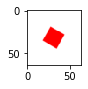

----
fill the square with green
green and a square


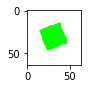

----
blue square
a square with blue filling


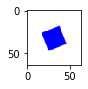

----
use purple ink for this square
a square that is purple


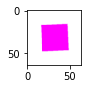

----
a triangle with red ink
a red colored triangle


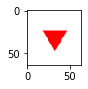

----
a triangle filled with green
i like a green colored triangle


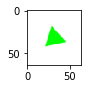

----
the color blue is perfect for this triangle
a triangle that is blue


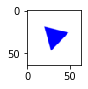

----
purple triangle
a purple triangle


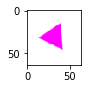

----
a star with red filling
just give me a red star


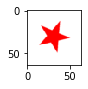

----
green star
the star should be green


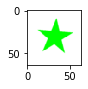

----
first i need a blue star
the color blue is perfect for this star


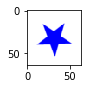

----
i need this purple star in my life
fill the star with purple


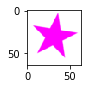

In [5]:
np.random.seed(42)
background = image_creation.make_default_image('white')
print("Single:", text_creation.generate_single_description("square", "blue"))
print("Multiple:")
for shape in dataset.all_shapes:
  for fill_color in dataset.all_fill_colors:
    print("----")
    for d in text_creation.generate_descriptions(2, shape, fill_color):
      print(d)
    img = image_creation.make_image(background, shape, fill_color, super_sampling=4)
    
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()

descriptions: (10,)
images: (10, 64, 64, 3)
labels: (10,)
10 -> ('star', 'blue')
i need this blue star in my life


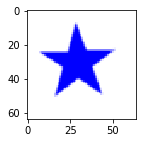

In [6]:
descriptions_dummy, images_dummy, labels_dummy = dataset.make_samples_numpy(10)

print("descriptions: {}\nimages: {}\nlabels: {}".format(
    descriptions_dummy.shape, images_dummy.shape, labels_dummy.shape))
print(labels_dummy[0], '->', dataset.all_dummy_classes[labels_dummy[0]])
print(descriptions_dummy[0])
plt.figure(figsize=(2,2))
plt.imshow(images_dummy[0])
plt.show()

# Text preprocessing: Vocabulary

Create the vocabulary (a mapping from each word to an index), which includes helpers `str_to_seq` and `seq_to_str` to map from strings to sequences of indices and vice versa.

In [7]:
all_words = text_creation.get_template_words() | set(dataset.all_shapes) | set(dataset.all_fill_colors)
vocab = Vocabulary(all_words)

print("Vocabulary ({}): {}".format(vocab.size, vocab.words_by_index))
test_str = "make a blue unknown square"
test_seq = vocab.str_to_seq(test_str)
print("Example:", test_str, '-->', test_seq, '-->', vocab.seq_to_str(test_seq))

Vocabulary (59): ['.', 'a', 'and', 'be', 'best', 'better', 'blue', 'change', 'color', 'colored', 'draw', 'drawn', 'dream', 'enjoy', 'fill', 'filled', 'filling', 'first', 'for', 'generate', 'give', 'green', 'i', 'in', 'ink', 'is', 'it', 'just', 'life', 'like', 'make', 'me', 'my', 'need', 'of', 'paint', 'perfect', 'please', 'prefer', 'purple', 'really', 'red', 'shape', 'should', 'show', 'square', 'star', 'that', 'the', 'this', 'to', 'triangle', 'try', 'use', 'want', 'with', 'would', '[OOV]', '[END]']
Example: make a blue unknown square --> [30, 1, 6, 57, 45, 58] --> make a blue [OOV] square [END]


# [1] Image + Text encoder

## Data loader

Generate train & validation datasets (for now in memory) and make them available as `torch.utils.data.DataLoader` objects.

The datasets are generated in a deterministic way, which can be controlled by the `random_seed` parameter.

If our entire training set becomes too large for memory at some point, we probably want to create our own `DataLoader` which only generates one batch at a time until the epoch is over, then starts over by re-seeding.

In [0]:
num_train = 51200 if pretrained_joint_model_path is None else 128
num_val = 2560
num_test = 1280
batch_size = 128

# Triplet dataset.
triplet_train_dataset = dataset.make_triplet_dataset(num_train, vocab, 14, train=True, blacklist=train_blacklist)
#triplet_train_dataset = dataset.make_triplet_dataset(num_train, vocab, 14, train=True)
triplet_val_dataset = dataset.make_triplet_dataset(num_val, vocab, 7331, train=False)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_dataset, batch_size, shuffle=False)
test_dataset = dataset.make_dataset(num_test, vocab, 1427)

footprint = sum(t.nelement() * t.element_size() for t in triplet_train_dataset.tensors) / 1024 / 1024
print("Training set size: %.0f MiB" % footprint)

# print('single sample shape:', [t.size() for t in train_dataset[0]])
# print(train_dataset[0][-1], vocab.seq_to_str(train_dataset[0][0]))
# print(val_dataset[0][-1], vocab.seq_to_str(val_dataset[0][0]))
# print('--------------')
print('single sample shapes of triplet dataset:')
print([t.size() for t in triplet_train_dataset[0]])
print('single sample example text descriptions:')
print('Anchor: %s' %(vocab.seq_to_str(triplet_train_dataset[0][2])))
print('Positive Example: %s' %(vocab.seq_to_str(triplet_train_dataset[0][0])))
print('Negative Example: %s' %(vocab.seq_to_str(triplet_train_dataset[0][4])))

In [0]:
def get_num_unique_descriptions(ds) -> int:
  return len(set(",".join(str(i) for i in ixs) for ixs in ds.tensors[0].tolist()))

print("Unique descriptions:")
print("  per class:", len(text_creation._baked_description_templates))
print("  in total:", len(dataset.all_dummy_classes)*len(text_creation._baked_description_templates))
print("  present in training set:", get_num_unique_descriptions(triplet_train_dataset))
print("  present in validation set:", get_num_unique_descriptions(triplet_val_dataset))

## Train

The displayed accuracy is the accuracy of a 3-NN classifier. Currently that classifier only uses each respective batch, not the whole data.

In [10]:
joint_model = models.JointModel(vocab.words_by_index, 64, joint_embedding_size,
                                word_embedding_size, lstm_size=64,
                                path_to_glove=None,
                                #path_to_glove="repo/relevant_glove_dict.pkl",
                                conv_layers=[32, 64, 64, 128, 128], use_batch_norm=False, image_dropout=0)

print("Joint model params: text_enc={}, image_enc={}, total={}".format(
    models.count_params(joint_model.text_enc), models.count_params(joint_model.image_enc), models.count_params(joint_model)))
print(joint_model)

if not pretrained_joint_model_path:
  ts = Solver(optim_args={'lr': 2e-4, 'weight_decay': 1e-3})
  ts.train(joint_model, triplet_train_loader, triplet_val_loader, num_epochs=10, log_nth=100, snapshot_interval=2)
  joint_model.eval()
  models.save_model("joint_model", joint_model)
else:
  print("Skipping training because a pretrained model is available.")

Joint model params: text_enc=37121, image_enc=310592, total=347713
JointModel(
  (text_enc): TextEncoder(
    (word_embedding): Embedding(59, 51, padding_idx=0)
    (rnn): LSTM(51, 64, batch_first=True)
    (final_linear): Linear(in_features=64, out_features=64, bias=True)
  )
  (image_enc): ImageEncoder(
    (cnn): Sequential(
      (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (actv0): ReLU()
      (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (actv1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (actv2): ReLU()
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act

## Visualize training curves

In [0]:
if 'ts' in globals():
  train_loss_history = ts.train_loss_history
  val_loss_history = ts.val_loss_history

  x_iterations = np.asarray(range(len(train_loss_history))) / (len(train_loss_history) // len(val_loss_history))
  x_epochs = np.asarray(range(1, len(val_loss_history)+1))

  f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  #ax1.set_ylim([0, 2])
  ax1.plot(x_iterations, train_loss_history, 'b')
  ax1.plot(x_epochs, val_loss_history, 'r', linewidth=3)

  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.plot(x_epochs, ts.train_acc_history, 'b')
  ax2.plot(x_epochs, ts.val_acc_history, 'r', linewidth=3)

  plt.show()

In [12]:
if pretrained_joint_model_path:
  joint_model.load_state_dict(torch.load(pretrained_joint_model_path, map_location=device))
  joint_model.to(device)
  print("Loaded pretrained model:", pretrained_joint_model_path)

Loaded pretrained model: repo/trained-models/joint_model--347713--2020-01-21T22-08.pt


## Visualize joint embedding results

using PCA

Inferring ...
Computing projection ...
PCA covered variance: [0.562892   0.43292275]
PCA covered variance: [0.5627435 0.4364237]
PCA covered variance: [0.5601656  0.43240684]
blacklisted class ('star', 'red') highlighted in gray


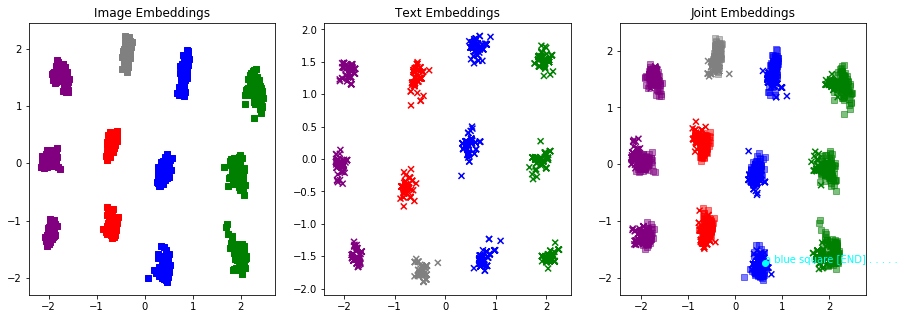

In [13]:
#asdf #@title {run: 'auto'}

def project_2d(values, **kwargs):
  pca = PCA(n_components=2, **kwargs)
  result = pca.fit_transform(values)
  print('PCA covered variance:', pca.explained_variance_ratio_)
  return result, pca

text_test, image_test, labels_test = test_dataset.tensors

#snapi = 4  #@param {type: 'slider', min: 0, max: 5}
#joint_model.load_state_dict(ts.model_snapshots[snapi])

# for i, snap in enumerate(ts.model_snapshots):
#   print('Snapshot #', i)
#   joint_model.load_state_dict(snap)
if True:

  print('Inferring ...')
  embedding_image_test = joint_model.image_enc(image_test.to(device)).detach().cpu().numpy()
  embedding_text_test = joint_model.text_enc(text_test.to(device)).detach().cpu().numpy()
  embedding_combined = np.concatenate((embedding_text_test, embedding_image_test))

  print('Computing projection ...')
  image_2d, _ = project_2d(embedding_image_test)
  text_2d, _ = project_2d(embedding_text_test)
  combined_2d, combined_pca = project_2d(embedding_combined)


  xs = [x[0] for x in image_2d]
  ys = [x[1] for x in image_2d]

  xs2 = [x[0] for x in text_2d]
  ys2 = [x[1] for x in text_2d]

  xs3 = [x[0] for x in combined_2d]
  ys3 = [x[1] for x in combined_2d]

  all_cols = len(dataset.all_shapes) * dataset.all_fill_colors
  #all_cols = len(dataset.all_fill_colors)*['red'] + len(dataset.all_fill_colors)*['cyan'] + len(dataset.all_fill_colors)*['green'] + len(dataset.all_fill_colors)*['blue']
  for blacklisted, c in zip(train_blacklist, ['gray', 'black']):
    print('blacklisted class', blacklisted, 'highlighted in', c)
    if blacklisted in dataset.all_dummy_classes:
      all_cols[dataset.all_dummy_classes.index(blacklisted)] = c
  cols = [all_cols[clazz] for clazz in labels_test]

  # Note: marker param does not accept list, so cannot do it like this :(
  # all_markers = len(dataset.all_fill_colors) * ['s'] + len(dataset.all_fill_colors) * ['^']
  # markers = [all_markers[clazz if clazz < 5 else clazz - 4] for clazz in labels_test]

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
  axes[0].scatter(xs, ys, c=cols, marker='s')
  axes[0].title.set_text("Image Embeddings")
  axes[1].scatter(xs2, ys2, c=cols, marker='x')
  axes[1].title.set_text("Text Embeddings")

  # Scatter text points.
  num_test = embedding_text_test.shape[0]
  axes[2].scatter(xs3[:num_test], ys3[:num_test], c=cols, marker='x')
  # Scatter image points.
  axes[2].scatter(xs3[num_test:], ys3[num_test:], c=cols, alpha=0.5, marker='s')
  axes[2].title.set_text("Joint Embeddings")
  #axes[2].set_ylim(axes[2].get_xlim())
  
  ti = 0
  axes[2].scatter(xs3[ti], ys3[ti], c='cyan', marker='o')
  axes[2].annotate(vocab.seq_to_str(text_test[ti]), combined_2d[ti], c='cyan')
  plt.show()

## Investigate word embeddings

[0, 41, 21, 6, 39, 45, 51, 46, 58]
PCA covered variance: [0.2852952  0.19036611]


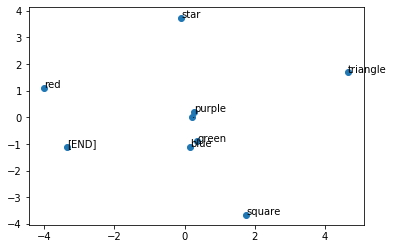

Padding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Nearest neighbors:
           .: better should in really just dream shape it would purple (d: [3.06 ... 3.78])
         red: . [END] is filling me [OOV] dream really should just (d: [5.84 ... 6.53])
       green: . in of should really colored and just blue would (d: [4.88 ... 6.03])
        blue: . is really better would should just [END] try colored (d: [3.98 ... 5.41])
      purple: . better just try this it should shape show use (d: [3.78 ... 5.44])
      square: . need use and dream should just filling better blue (d: [5.52 ... 6.37])
    triangle: . should just would blue shape ink try use dream (d: [5.76 ... 6.76])
        star: . in try should just better really purple dream [OOV] (d: [5.10 ... 6.14])
       [END]: . better blue filling really use colored purple is should (d: [5.00 ... 6.02])
d(red, green) = 7.75725

In [14]:
emb_debug_in = [0] + vocab.str_to_seq("red green blue purple square triangle star")
print(emb_debug_in)
emb_matrix = joint_model.text_enc.word_embedding.weight.detach().cpu()
emb_debug_out = emb_matrix[emb_debug_in]

emb_2d, _ = project_2d(emb_debug_out)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
for wi, pos in zip(emb_debug_in, emb_2d):
  plt.annotate(vocab.words_by_index[wi], pos)
plt.show()

wnn = NearestNeighbors(10)
wnn.fit(emb_matrix)
wdistances, windices = wnn.kneighbors()

print("Padding:", emb_matrix[0].numpy())
print("Nearest neighbors:")
for wordi, neighbors, distances in zip(emb_debug_in, windices[emb_debug_in], wdistances[emb_debug_in]):
  print("%12s: %s (d: [%.2f ... %.2f])" % (
      vocab.words_by_index[wordi],
      vocab.seq_to_str(neighbors.tolist()),
      distances[0], distances[-1]
    ))

for a, b in [("red", "green"), ("red", "blue"), ("green", "blue")]:
  print( "d(%s, %s) = %f" % (a, b, np.linalg.norm(emb_matrix[vocab.indices_by_word[a]] - emb_matrix[vocab.indices_by_word[b]])))
print("----")
for a, b in itertools.product(dataset.all_shapes, dataset.all_shapes):
  if a == b: continue
  print( "d(%s, %s) = %f" % (a, b, np.linalg.norm(emb_matrix[vocab.indices_by_word[a]] - emb_matrix[vocab.indices_by_word[b]])))

In [0]:
f = open("embeddings.txt", "w")
f.writelines("\r\n".join("\t".join(str(x.item()) for x in row) for row in emb_matrix))
f.close()
f = open("embeddings-words.txt", "w")
f.writelines("\r\n".join(vocab.words_by_index))
f.close()

## Visualize CONV layer outputs

Sequential(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (actv0): ReLU()
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (actv1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Hidden output size: (16, 16, 64)


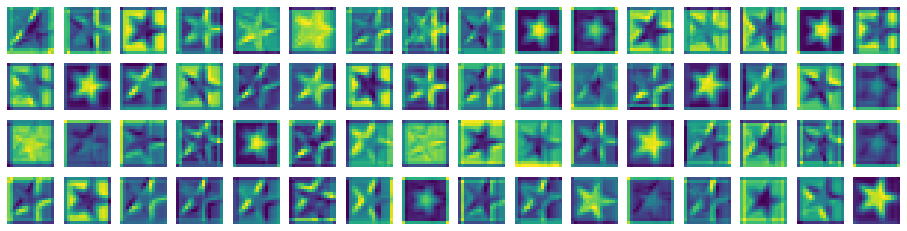

In [91]:
vis_layer_num = 7
vis_sample_num = 4
print(joint_model.image_enc.cnn[:vis_layer_num])

vis_input = test_dataset[:10][1]
vis_input_view = vis_input.permute(0, 3, 1, 2).to(device)
vis_embed = joint_model.image_enc.cnn[:vis_layer_num](vis_input_view)

vis_embed_im = vis_embed[vis_sample_num].detach().cpu().permute(1, 2, 0).numpy()
print("Hidden output size:", vis_embed_im.shape)
f, ax = plt.subplots(nrows=4, ncols=16, sharex=True, sharey=True, squeeze=True,
                     figsize=(16, 4))
for c in range(min(64, vis_embed_im.shape[-1])):
  ax_x = c // 4
  ax_y = c % 4
  ax[ax_y, ax_x].axis('off')
  ax[ax_y, ax_x].imshow(vis_embed_im[:, :, c])
plt.show()

## Retrieve nearest neighbors in embedding space

 text <> image distances: [0.32269207 0.3235581  0.32626075 0.32967735 0.3306527  0.33366414
 0.3338023  0.33491862 0.33763141 0.33855607]
image <> image distances: [0.         0.03639245 0.05308921 0.05938342 0.07673711 0.08163946
 0.08208642 0.08396909 0.08722931 0.09168625]


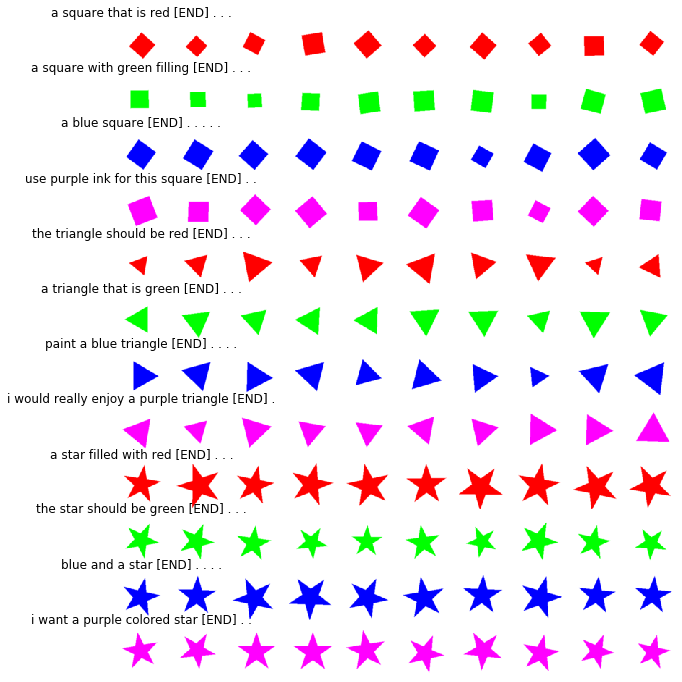

In [17]:
num_neighbors = 10

# Show one sample from each class.
labels_test_list = labels_test.tolist()
sample_indices = [labels_test_list.index(c) for c in range(len(dataset.all_dummy_classes))] #if c not in [0, 4, 7, 9, 10]]
num_samples = len(sample_indices)

vis_embedding_text_test = embedding_text_test[sample_indices]
vis_text_test = text_test[sample_indices]

nbrs = NearestNeighbors(n_neighbors=num_neighbors)
nbrs.fit(embedding_image_test)
distances, indices = nbrs.kneighbors(vis_embedding_text_test)

print(" text <> image distances:", distances[0])
print("image <> image distances:", nbrs.kneighbors(embedding_image_test[0:1])[0][0])

fig, axes = plt.subplots(nrows=num_samples, ncols=num_neighbors, figsize=(num_neighbors*1, num_samples*1))
for x in range(num_samples):
  axes[x,0].set_title(vocab.seq_to_str(vis_text_test[x]))
  for n in range(num_neighbors):
    ax = axes[x,n]
    ax.set_axis_off()
    ax.imshow(image_test[indices[x, n]])

plt.show()

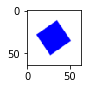

label: tensor(2, dtype=torch.int32)
desc : a blue square [END] . . . . .
dummy class: ('square', 'blue')
[X] please generate a blue colored square [END] . .
[X] a square with blue filling [END] . . .
[X] blue and a square [END] . . . .
[X] just draw a blue colored square [END] . .


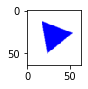

label: tensor(6, dtype=torch.int32)
desc : paint a blue triangle [END] . . . .
dummy class: ('triangle', 'blue')
[X] make a blue colored triangle [END] . . .
[X] use blue ink for this triangle [END] . .
[X] blue triangle [END] . . . . . .


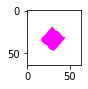

label: tensor(3, dtype=torch.int32)
desc : use purple ink for this square [END] . .
dummy class: ('square', 'purple')
[X] fill the square with the color purple [END] .
[X] purple and a square [END] . . . .


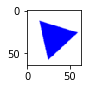

label: tensor(6, dtype=torch.int32)
desc : a blue triangle [END] . . . . .
dummy class: ('triangle', 'blue')
[X] fill the triangle with blue [END] . . .
[X] a triangle filled with blue [END] . . .


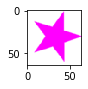

label: tensor(11, dtype=torch.int32)
desc : i want a purple colored star [END] . .
dummy class: ('star', 'purple')
[X] i need a purple colored star [END] . .
[X] generate a purple colored star [END] . . .
[X] please generate a purple colored star [END] . .
[X] purple star [END] . . . . . .
[X] a purple colored star [END] . . . .


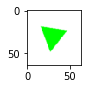

label: tensor(5, dtype=torch.int32)
desc : a triangle that is green [END] . . .
dummy class: ('triangle', 'green')
[X] the triangle should be green [END] . . .
[X] fill the triangle with green [END] . . .


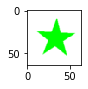

label: tensor(9, dtype=torch.int32)
desc : the star should be green [END] . . .
dummy class: ('star', 'green')
[X] the color green is perfect for this star [END]
[X] a green star [END] . . . . .


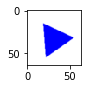

label: tensor(6, dtype=torch.int32)
desc : a triangle with blue ink [END] . . .
dummy class: ('triangle', 'blue')
[X] a triangle that is blue [END] . . .
[X] a triangle filled with blue [END] . . .


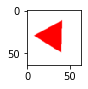

label: tensor(4, dtype=torch.int32)
desc : the triangle should be red [END] . . .
dummy class: ('triangle', 'red')
[X] just draw a red colored triangle [END] . .
[X] a red colored triangle [END] . . . .
[X] red and a triangle [END] . . . .


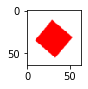

label: tensor(0, dtype=torch.int32)
desc : a square that is red [END] . . .
dummy class: ('square', 'red')
[X] i would really enjoy a red square [END] .
[X] the square should be red [END] . . .


In [18]:
num_samples = 10
num_neighbors = 10

nbrs = NearestNeighbors(n_neighbors=num_neighbors)
nbrs.fit(embedding_text_test)
distances, indices = nbrs.kneighbors(embedding_image_test[:num_samples])

for x in range(num_samples):
  plt.figure(figsize=(1,1))
  plt.imshow(image_test[x])
  plt.show()

  known = set()
  print("label:", labels_test[x])
  print("desc :", vocab.seq_to_str(text_test[x]))
  print("dummy class:", dataset.all_dummy_classes[labels_test[x]])
  for n in range(num_neighbors):
    s = vocab.seq_to_str(text_test[indices[x, n]])
    if not s in known:
      is_correct = labels_test[x] == labels_test[indices[x, n]]
      print(('[X]' if is_correct else '[ ]'), s)
      known.add(s)

## Quality measures

In [19]:
# Calculate quality measures of the embedding space clustering
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

labels_combined = np.concatenate((labels_test, labels_test))

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(embedding_combined, labels_combined)

predictions = knn_classifier.predict(embedding_combined)

precision = metrics.precision_score(labels_combined, predictions, average="macro")
recall = metrics.recall_score(labels_combined, predictions, average="macro")
f1 = metrics.f1_score(labels_combined, predictions, average="macro")

print("Precision: %s \nRecall: %s \nF1 Score: %s" %(precision, recall, f1))



Precision: 1.0 
Recall: 1.0 
F1 Score: 1.0


# [2] Image decoder GAN

Train a conditional GAN using embeddings from the text encoder as conditioning.

## Data loader

In [20]:
decoder_num_train = 30000
decoder_num_val = 300
decoder_batch_size = 100

gen_allowed_classes = dataset.all_dummy_classes # [('square', 'red'), ('triangle', 'red'), ('square', 'blue'), ('triangle', 'blue')]
gen_blacklist = [c for c in dataset.all_dummy_classes if not c in gen_allowed_classes]
if len(gen_allowed_classes) + len(gen_blacklist) != len(dataset.all_dummy_classes):
  raise ValueError("sanity check for gen_allowed_classes failed")

def make_decoder_dataset_text(n_samples, random_seed, text_encoder):
  np.random.seed(random_seed)
  description_tensors, image_tensors, labels = dataset.make_samples_tensors(n_samples, vocab, blacklist=gen_blacklist)

  embeddings = torch.zeros(n_samples, joint_embedding_size, dtype=torch.float32)
  for i in range(0, n_samples, batch_size):
    input_batch = description_tensors[i:i+batch_size].to(device)
    embeddings[i:i+batch_size] = text_encoder(input_batch).detach()
  
  return torch.utils.data.TensorDataset(embeddings, image_tensors, labels)

def make_decoder_dataset_images(n_samples, random_seed, image_encoder):
  np.random.seed(random_seed)
  _, images, labels = dataset.make_samples_numpy(n_samples, blacklist=gen_blacklist)

  image_tensors = torch.tensor(images, dtype=torch.float32)
  embeddings = torch.zeros(n_samples, joint_embedding_size, dtype=torch.float32)
  for i in range(0, n_samples, batch_size):
    input_batch = image_tensors[i:i+batch_size].to(device)
    embeddings[i:i+batch_size] = image_encoder(input_batch).detach()
  
  return torch.utils.data.TensorDataset(embeddings, image_tensors, torch.from_numpy(labels))

def make_decoder_dataset_all_modalities(n_samples, random_seed, image_encoder, text_encoder):
  np.random.seed(random_seed)

  description_tensors, image_tensors, labels = dataset.make_samples_tensors(n_samples, vocab)

  description_embeddings = text_encoder(description_tensors.to(device)).detach()
  image_embeddings = image_encoder(image_tensors.to(device)).detach()

  half = int(n_samples/2)

  embeddings = torch.cat((description_embeddings[:half], image_embeddings[half:]), 0)

  return torch.utils.data.TensorDataset(embeddings, image_tensors, labels)


decoder_train_dataset = make_decoder_dataset_text(decoder_num_train, 551334, joint_model.text_enc)
decoder_train_loader = torch.utils.data.DataLoader(decoder_train_dataset, decoder_batch_size, shuffle=True)
decoder_val_dataset = make_decoder_dataset_text(decoder_num_val, 97531, joint_model.text_enc)
decoder_val_loader = torch.utils.data.DataLoader(decoder_val_dataset, decoder_batch_size, shuffle=True)

100%|██████████| 30000/30000 [00:15<00:00, 1930.80it/s]


[14, 18, 11, 36, 2, 5, 9, 10, 1, 29, 3, 8, 17, 22, 0, 24, 15, 25, 26, 42, 4, 7, 12, 16]
torch.Size([24, 64])
torch.Size([2, 24, 64])


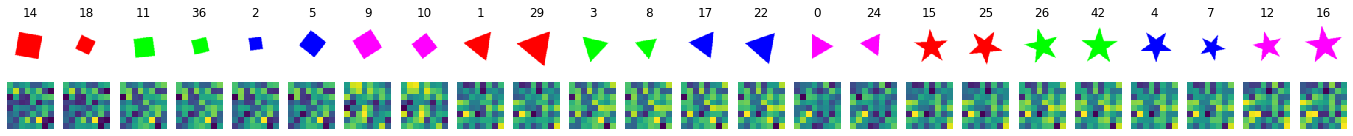

In [21]:
# Find 2 representative embeddings per included class/label and return them as a tensor.
def find_indices_for_label(label: int, num: int):
  found = 0
  results = []
  for i in range(decoder_num_val):
    if decoder_val_dataset.tensors[2][i] == label:
      results.append(i)
      found += 1
      if found >= num:
        break
  return results

occuring_class_labels = np.unique(decoder_val_dataset.tensors[2].numpy()).tolist()
debug_val_indices = list(itertools.chain.from_iterable(find_indices_for_label(label, 2) for label in occuring_class_labels))
debug_embeddings = decoder_val_dataset.tensors[0][debug_val_indices]
debug_real_images = decoder_val_dataset.tensors[1][debug_val_indices]
print(debug_val_indices)
print(debug_embeddings.shape)

print(debug_embeddings.unsqueeze(0).repeat(2, 1, 1).shape)

f, axes = plt.subplots(nrows=2, ncols=len(debug_val_indices), figsize=(len(debug_val_indices), 2))
for (ax, axembed), img, embed, i in zip(axes.transpose(), debug_real_images, debug_embeddings, debug_val_indices):
  ax.set_title(str(i))
  ax.axis('off')
  ax.imshow(img)
  axembed.axis('off')
  axembed.imshow(embed.reshape(8, 8))
plt.show()

## Train

In [22]:
latent_dim = 64
num_epochs = 100
learning_rate_gen = 1e-4
learning_rate_disc = 4e-4
adam_betas = (0.5, 0.999)

log_interval = 100
sample_interval = 800

generator = Generator(latent_dim + joint_embedding_size, 3)
discriminator = Discriminator(64, 3, joint_embedding_size)
generator.to(device)
discriminator.to(device)

print("Generator params: %d, discriminator params: %d" % (models.count_params(generator), models.count_params(discriminator)))
print(generator)
print(discriminator)

if not pretrained_generator_path:
  gan_solver = SolverCGAN(latent_dim, condition_input_for_save=debug_embeddings,
                    optim_args_generator={'lr': learning_rate_gen, 'betas': adam_betas},
                    optim_args_discriminator={'lr': learning_rate_disc, 'betas': adam_betas})
  gan_solver.train(generator, discriminator, decoder_train_loader, num_epochs=num_epochs, log_nth=log_interval, save_nth_batch=sample_interval)

  generator.eval()
  discriminator.eval()
  models.save_model('generator', generator)
  models.save_model('discriminator', discriminator)

else:
  if 'gan_solver' in globals(): del gan_solver
  generator.load_state_dict(torch.load(pretrained_generator_path, map_location=device))
  generator.to(device)
  print("Loaded pretrained generator:", pretrained_generator_path)
  if pretrained_discriminator_path:
    discriminator.load_state_dict(torch.load(pretrained_discriminator_path, map_location=device))
    discriminator.to(device)
    print("Loaded pretrained discriminator:", pretrained_discriminator_path)

Generator params: 394563, discriminator params: 270145
Generator(
  (first_lin): Linear(in_features=128, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (10): Tanh()
  )
)
Discr

## Visualize training curves

In [23]:
def chunk_smooth_values(values: list, chunk_size) -> list:
  remainder = len(values) % chunk_size
  if remainder > 0:
    values = values[:-remainder]
  num_splits = len(values) // chunk_size
  return [np.mean(losses) for losses in np.split(np.array(values), num_splits)]

if 'gan_solver' in globals():
  iter_per_epoch = len(decoder_train_loader)
  smooth_gen_losses = chunk_smooth_values(gan_solver.generator_loss_history, iter_per_epoch)
  smooth_disc_losses = chunk_smooth_values(gan_solver.discriminator_loss_history, iter_per_epoch)

  f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  ax1.set_title("Generator")
  ax1.set_xlabel("Iteration")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, max(smooth_gen_losses)*1.1])
  ax1.plot(gan_solver.generator_loss_history, 'b', alpha=0.2)
  ax1.plot(np.arange(0.5, len(smooth_gen_losses)+0.5) * iter_per_epoch, smooth_gen_losses, 'b')

  ax2.set_title("Discriminator")
  ax2.set_xlabel("Iteration")
  ax2.set_ylabel("Loss")
  ax2.set_ylim([0, max(smooth_disc_losses)*1.1])
  ax2.plot(gan_solver.discriminator_loss_history, 'b', alpha=0.2)
  ax2.plot(np.arange(0.5, len(smooth_disc_losses)+0.5) * iter_per_epoch, smooth_disc_losses, 'b')

  plt.show()
else:
  print("Train a model first to see loss curves.")

Train a model first to see loss curves.


## Show results

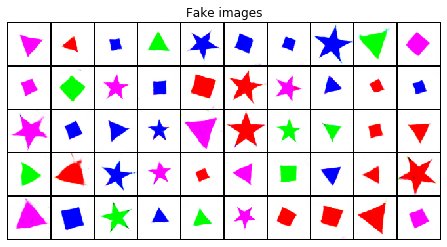

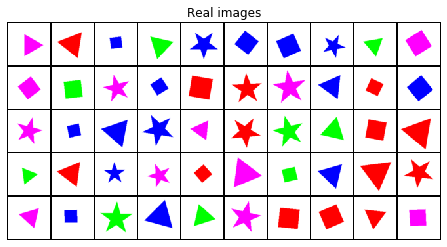

In [24]:
generator.eval()
discriminator.eval()
num_test = 100

test_real_images = decoder_val_dataset.tensors[1][:num_test].to(device)
test_embedding = decoder_val_dataset.tensors[0][:num_test].to(device)
test_z = torch.randn(num_test, latent_dim).to(device)

test_fake_images = generator(torch.cat([test_z, test_embedding], 1))

grid = make_grid(test_fake_images[:50].permute(0,3,1,2), nrow=10).detach().cpu().permute(1,2,0).numpy()
plt.figure(figsize=(8,4))
plt.title('Fake images')
plt.imshow(grid)
plt.axis('off')
plt.show()

grid = make_grid(test_real_images[:50].permute(0,3,1,2), nrow=10).detach().cpu().permute(1,2,0).numpy()
plt.figure(figsize=(8,4))
plt.title('Real images')
plt.imshow(grid)
plt.axis('off')
plt.show()

In [25]:
dtest_fake = discriminator(test_fake_images, test_embedding).detach().cpu().numpy()
dtest_real = discriminator(test_real_images, test_embedding).detach().cpu().numpy()
print("Correct fake:", np.sum(dtest_fake < 0.5), "/", dtest_fake.shape[0], "- mean:", np.mean(dtest_fake))
print("Correct real:", np.sum(dtest_real > 0.5), "/", dtest_real.shape[0], "- mean:", np.mean(dtest_real))

Correct fake: 9 / 100 - mean: 0.7470174
Correct real: 100 / 100 - mean: 0.9054666


Pick one text description per class from the validation set and show some generated images for it for different values of `z`.

a square that is red 


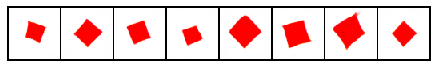

a square with green filling 


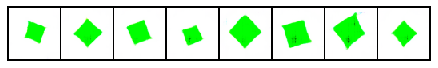

a blue square 


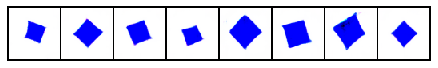

use purple ink for this square 


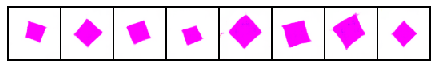

the triangle should be red 


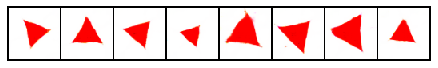

a triangle that is green 


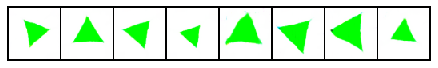

paint a blue triangle 


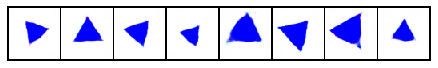

i would really enjoy a purple triangle 


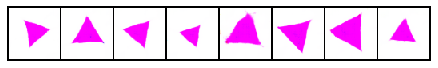

a star filled with red 


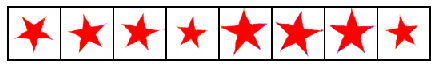

the star should be green 


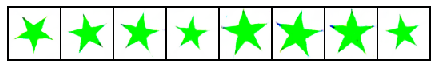

blue and a star 


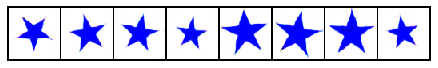

i want a purple colored star 


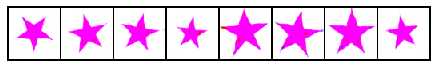

In [94]:
num_z = 8

# From text
test_labels_all = test_dataset.tensors[2].tolist()
indices = [test_labels_all.index(c) for c in range(len(dataset.all_dummy_classes))]
text_seqs = test_dataset.tensors[0][indices]
text_embs = joint_model.text_enc(text_seqs.to(device))

custom_z = torch.randn(num_z, latent_dim).to(device)
for i in range(len(dataset.all_dummy_classes)):
  #custom_seq_in = torch.as_tensor(vocab.str_to_seq(custom_text_in), dtype=torch.long, device=device).unsqueeze(0)
  #custom_emb = joint_model.text_enc(custom_seq_in)
  custom_emb = text_embs[i]

  custom_gen_img = generator(torch.cat([custom_z, custom_emb.repeat(num_z, 1)], 1)).detach().cpu()

  t = vocab.seq_to_str(text_seqs[i])
  print(t[:t.index('[END]')])
  plt.figure(figsize=(num_z,1))
  plt.axis('off')
  plt.imshow(make_grid(custom_gen_img.permute(0,3,1,2), nrow=num_z).permute(1,2,0))
  plt.show()

## Show results (a different way)

Input: generate a red square [END] . . . .


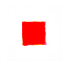

Input: this square should be green [END] . . .


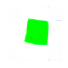

Input: a blue colored square [END] . . . .


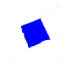

Input: the color purple is perfect for this square [END]


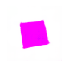

Input: i need this red triangle in my life [END]


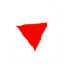

Input: this triangle should be green [END] . . .


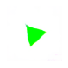

Input: i need this blue triangle in my life [END]


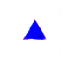

Input: purple and a triangle [END] . . . .


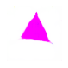

Input: red star [END] . . . . . .


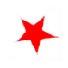

Input: a star that is green [END] . . .


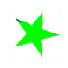

Input: blue and a star [END] . . . .


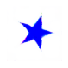

Input: purple star [END] . . . . . .


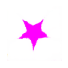

In [27]:
def _prepare_single_input(x):
  if not torch.is_tensor(x):
    x = torch.tensor(x)
  if x.ndim < 2:
    x = x.unsqueeze(0)
  return x.to(device)

def sample_z(num):
  return torch.randn(num, latent_dim)

def decode_from_text(input: str, z: torch.Tensor = None) -> np.ndarray:
  return decode_from_seq(vocab.str_to_seq(input), z)

def decode_from_seq(input_seq, z: torch.Tensor = None) -> np.ndarray:
  return decode_from_embedding(seq_to_embedding(input_seq), z)

def seq_to_embedding(input_seq) -> torch.Tensor:
  x = _prepare_single_input(input_seq)
  x = joint_model.text_enc(x)
  return x

def decode_from_embedding(embedding, z: torch.Tensor = None) -> np.ndarray:
  if z is None:
    z = sample_z(1)

  z = _prepare_single_input(z)
  x = _prepare_single_input(embedding)
  y = generator(torch.cat([z, x], 1))
  return y[0].detach().cpu().numpy()


val_class_labels = triplet_val_dataset.tensors[-1].tolist()
indices = [val_class_labels.index(c) for c in range(len(dataset.all_dummy_classes))]
for i, n in enumerate(indices):
  x = triplet_val_dataset[n][0]
  print("Input:", vocab.seq_to_str(x))
  img = decode_from_seq(x)
  plt.figure(figsize=(1,1))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

## Interactive text --> image generation

Input (raw): give me a red star
Input (seq): give me a red star [END]
Output:


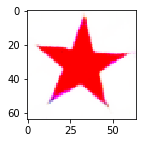

In [83]:
#@title {run: 'auto'}
test_str = "give me a red star"  #@param {type: 'string'}

print("Input (raw):", test_str)
print("Input (seq):", vocab.seq_to_str(vocab.str_to_seq(test_str)))
img = decode_from_text(test_str)
print("Output:")
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

## Experiment: Interpolate between two image embeddings

From ('triangle', 'blue') to ('square', 'green')


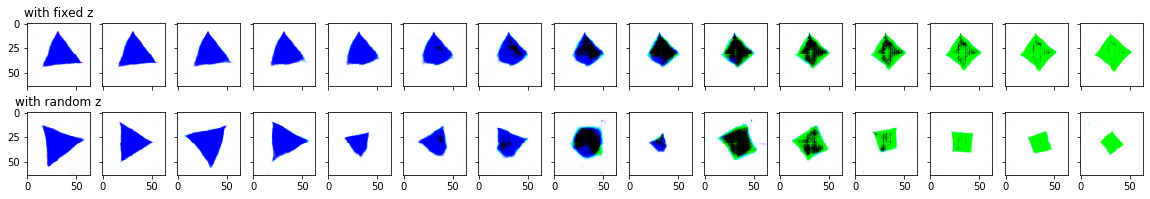

In [29]:
embed_a, _, label_a = decoder_val_dataset[153]
embed_b, _, label_b = decoder_val_dataset[118]
print("From", dataset.all_dummy_classes[label_a], "to", dataset.all_dummy_classes[label_b])

steps = 15
z = sample_z(1)
fig, axes = plt.subplots(nrows=2, ncols=steps, figsize=(20, 3), sharex=True, sharey=True)
axes[0,0].set_title('with fixed z')
axes[1,0].set_title('with random z')
for i, t in enumerate(np.linspace(0, 1, steps)):
  embed = t * embed_b + (1 - t) * embed_a
  img = decode_from_embedding(embed, z)
  axes[0,i].imshow(img)
  img = decode_from_embedding(embed)
  axes[1,i].imshow(img)

plt.show()

# [3] Modifier

Next comes the network that modifies embedding vectors based on another text input.

## Data loader

In [30]:
modifier_num_train = 50000
modifier_num_val = 250
modifier_batch_size = 250

modifier_train_dataset = dataset.make_modifier_dataset(modifier_num_train, vocab, joint_model.text_enc, 6660)
modifier_train_loader = torch.utils.data.DataLoader(modifier_train_dataset, modifier_batch_size, shuffle=True)
modifier_val_dataset = dataset.make_modifier_dataset(modifier_num_val, vocab, joint_model.text_enc, 7771)
modifier_val_loader = torch.utils.data.DataLoader(modifier_val_dataset, modifier_batch_size, shuffle=True)

100%|██████████| 250/250 [00:00<00:00, 4953.19it/s]


In [31]:
mod_footprint = sum(t.nelement() * t.element_size() for t in modifier_train_dataset.tensors) / 1024 / 1024
print("Training set size: %.0f MiB" % mod_footprint)
print('Sample shape:', [t.size() for t in modifier_train_dataset[0]])
print('Train modification string example:', vocab.seq_to_str(modifier_train_dataset[9][1]))

Training set size: 27 MiB
Sample shape: [torch.Size([64]), torch.Size([6]), torch.Size([64])]
Train modification string example: a square would be better [END]


## Train

In [32]:
num_epochs = 20

modifier_model = models.SemanticModifier(joint_embedding_size, vocab.size, word_embedding_size, 64, 64)
print("Modifier params:", models.count_params(modifier_model))
print(modifier_model)

ms = SolverModifier(optim_args={'lr':1e-4, 'weight_decay': 1e-4}, loss_func=torch.nn.MSELoss())
ms.train(modifier_model, modifier_train_loader, modifier_val_loader, num_epochs, log_nth=600)

modifier_model.eval()
models.save_model("modifier_model", modifier_model)

Modifier params: 45377
SemanticModifier(
  (word_embedding): Embedding(59, 51, padding_idx=0)
  (rnn): LSTM(51, 64, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
)
START TRAIN FOR 4000 ITERATIONS.
[Epoch 1/20] TRAIN loss: 0.076; VAL loss: 0.047
[Epoch 2/20] TRAIN loss: 0.029; VAL loss: 0.015
[Epoch 3/20] TRAIN loss: 0.012; VAL loss: 0.008
[Iteration 600/4000] TRAIN loss: 0.039 (157.2 iter/s, 39303.9 samples/s)
[Epoch 4/20] TRAIN loss: 0.004; VAL loss: 0.002
[Epoch 5/20] TRAIN loss: 0.001; VAL loss: 0.001
[Epoch 6/20] TRAIN loss: 0.001; VAL loss: 0.001
[Iteration 1200/4000] TRAIN loss: 0.002 (162.5 iter/s, 40616.7 samples/s)
[Epoch 7/20] TRAIN loss: 0.001; VAL loss: 0.001
[Epoch 8/20] TRAIN loss: 0.001; VAL loss: 0.001
[Epoch 9/20] TRAIN loss: 0.001; VAL loss: 0.001
[Iteration 1800/4000] TRAIN loss: 0.001 (161.2 iter/s, 40290.1 samples/s)
[Epoch 10/20] TR

## Visualize training curves

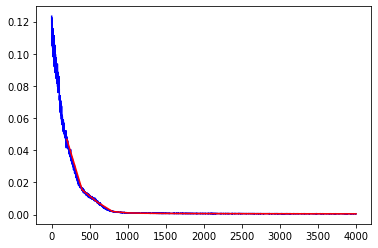

In [33]:
train_loss_history = ms.train_loss_history
val_loss_history = ms.val_loss_history

x_train_loss = range(len(train_loss_history))
x_val_loss = np.asarray(range(1, len(val_loss_history)+1)) * (len(train_loss_history) // len(val_loss_history))

plt.plot(x_train_loss, train_loss_history, 'b')
plt.plot(x_val_loss, val_loss_history, 'r')
plt.show()

## Retrieve nearest neighboring images

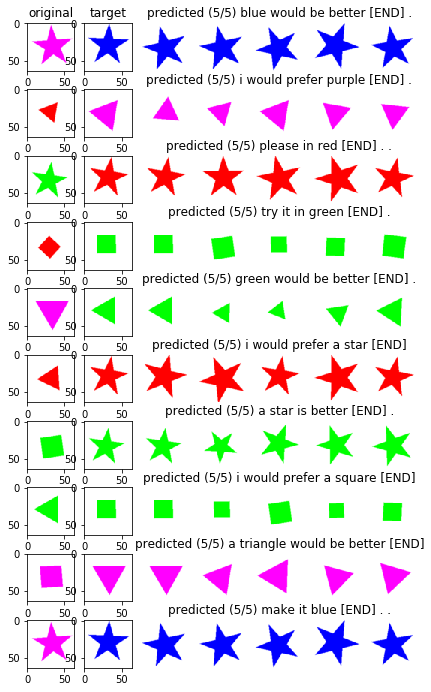

In [34]:
num_samples = 10
num_neighbors = 5

val_in_embeddings, val_mod_sequences, val_out_embeddings = modifier_val_dataset.tensors
val_model_outputs = modifier_model(val_in_embeddings.to(device), val_mod_sequences.to(device)).detach().cpu()

nbrs = NearestNeighbors(n_neighbors=num_neighbors)
nbrs.fit(embedding_image_test)

_, indices_in = nbrs.kneighbors(val_in_embeddings[:num_samples], n_neighbors=1)
_, indices_out = nbrs.kneighbors(val_out_embeddings[:num_samples], n_neighbors=1)
_, indices_pred = nbrs.kneighbors(val_model_outputs[:num_samples])

fig, axes = plt.subplots(nrows=num_samples, ncols=num_neighbors+2, figsize=(num_neighbors*1+2, num_samples*1.2))
axes[0,0].set_title('original')
axes[0,1].set_title('target')
for x in range(num_samples):
  axes[x,0].imshow(image_test[indices_in[x, 0]])
  axes[x,1].imshow(image_test[indices_out[x, 0]])
  target_label = labels_test[indices_out[x, 0]].item()
  correct_num = 0
  for n in range(0, num_neighbors):
    correct_num += 1 if labels_test[indices_pred[x, n]].item() == target_label else 0
    ax = axes[x,n+2]
    ax.set_axis_off()
    ax.imshow(image_test[indices_pred[x, n]])
  
  axes[x,2+num_neighbors//2].set_title('predicted ({}/{}) {}'.format(correct_num, num_neighbors,
                                                                     vocab.seq_to_str(val_mod_sequences[x])))

plt.show()

# [4] Calculate quality measures

## Get necessary data for metrics ready

In [35]:
n_samples = 2000
text_encoder = joint_model.text_enc
random_seed = 66

in_embeddings_tensor, image_in, label_in, sequences_mod, out_embeddings_tensor, image_out, label_out = dataset.make_test_data(n_samples, vocab, text_encoder, random_seed=random_seed, blacklist=[])

100%|██████████| 2000/2000 [00:02<00:00, 944.08it/s]
/content/repo/dataset.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_out = torch.tensor(label_in, dtype=torch.float32)


In [0]:
generator.to(device)
latent_dim = 64

z1 = torch.randn(n_samples, latent_dim).to(device)
z2 = torch.randn(n_samples, latent_dim).to(device)

gan_in = torch.cat([z1, in_embeddings_tensor.to(device)], 1)
gan_out = torch.cat([z2, out_embeddings_tensor.to(device)], 1)
images_generated_in = generator(gan_in.to(device))
images_generated_out = generator(gan_out.to(device))

## Wasserstein color distance

In [97]:
from scipy.stats import wasserstein_distance
import numpy as np

def get_histogram(img):
  '''
  Get the histograms of an image.
  The histograms values sum to 1.
  '''

  h, w, d = img.shape
  hist_r = [0.0] * 256
  hist_g = [0.0] * 256
  hist_b = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist_r[int(img[i, j, 0])] += 1
      hist_g[int(img[i, j, 1])] += 1
      hist_b[int(img[i, j, 2])] += 1

  return np.array(hist_r)/(h * w), np.array(hist_g)/(h * w), np.array(hist_b)/(h * w)

def get_wasserstein_distance(img1, img2, mean=True):

  hist_r_1, hist_g_1, hist_b_1 = get_histogram(img1)
  hist_r_2, hist_g_2, hist_b_2 = get_histogram(img2)

  dist_r = wasserstein_distance(hist_r_1, hist_r_2)
  dist_g = wasserstein_distance(hist_g_1, hist_g_2)
  dist_b = wasserstein_distance(hist_b_1, hist_b_2)

  if mean:
    return np.mean((dist_r, dist_g, dist_b))
  else:
    return np.sum((dist_r, dist_g, dist_b))

calculate_distance = True
if calculate_distance:
  distances_in = []
  distances_out = []

  for i in range(n_samples):

    img_real_in = image_in.detach().cpu().numpy()[i]

    img_real_out = image_out.detach().cpu().numpy()[i]

    img_gan_in = images_generated_in.detach().cpu().numpy()[i]

    img_gan_out = images_generated_out.detach().cpu().numpy()[i]

    distances_in.append(get_wasserstein_distance(img_real_in, img_gan_in))
    distances_out.append(get_wasserstein_distance(img_real_out, img_gan_out))

  print("Wasserstein distance image creation: %s +- %s" % (np.mean(distances_in), np.std(distances_in)))
  print("Wasserstein distance after modification: %s +- %s" % (np.mean(distances_out), np.std(distances_out)))

Wasserstein distance image creation: 0.002276628494262695 +- 0.0006399065409889245
Wasserstein distance after modification: 0.002264627774556478 +- 0.0006389674378291942


# Final tool

Enter any description you want (e.g. "give me a red star") and find a picture you like. To build up on that picture, enter a modification string (e.g. "purple would be better").

Input (raw): i want a star that is red
Input (seq): i want a star that is red [END]


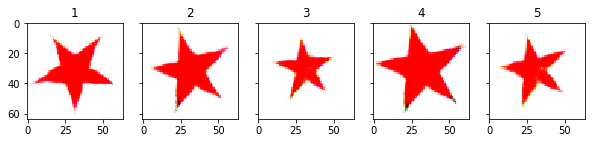

In [87]:
#@title {run: 'auto'}
test_str = "i want a star that is red"  #@param {type: 'string'}
num_outputs =   5#@param {type: 'number'}

print("Input (raw):", test_str)
print("Input (seq):", vocab.seq_to_str(vocab.str_to_seq(test_str)))
test_embedding1 = seq_to_embedding(vocab.str_to_seq(test_str))

z = sample_z(num_outputs)
fig, axes = plt.subplots(nrows=1, ncols=z.size(0), figsize=(z.size(0)*2, 2), sharex=True, sharey=True)
for i in range(z.size(0)):
  img = decode_from_embedding(test_embedding1, z[i])
  axes[i].set_title(str(i+1))
  axes[i].imshow(img)
plt.show()

Modification input (raw): purple would be better
Modification input (seq): purple would be better [END]
Output:


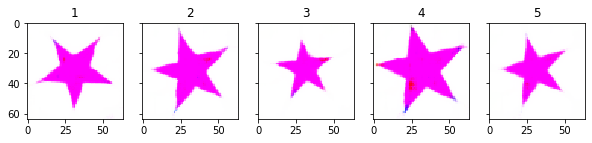

In [88]:
#@title {run: 'auto'}
test_mod_str = "purple would be better"  #@param {type: 'string'}

mod_input = torch.tensor(vocab.str_to_seq(test_mod_str), dtype=torch.long, device=device)
test_embedding2 = modifier_model(test_embedding1, mod_input.unsqueeze(0)).detach().cpu()

print("Modification input (raw):", test_mod_str)
print("Modification input (seq):", vocab.seq_to_str(vocab.str_to_seq(test_mod_str)))
print("Output:")
fig, axes = plt.subplots(nrows=1, ncols=z.size(0), figsize=(10, 2), sharex=True, sharey=True)
for i in range(z.size(0)):
  img = decode_from_embedding(test_embedding2, z[i])
  axes[i].set_title(str(i+1))
  axes[i].imshow(img)
plt.show()